## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [7]:
pip install ucimlrepo

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

Скачивание датасета...
Скачивание завершено.
Распаковка завершена.
Файлы датасета найдены, загрузка...


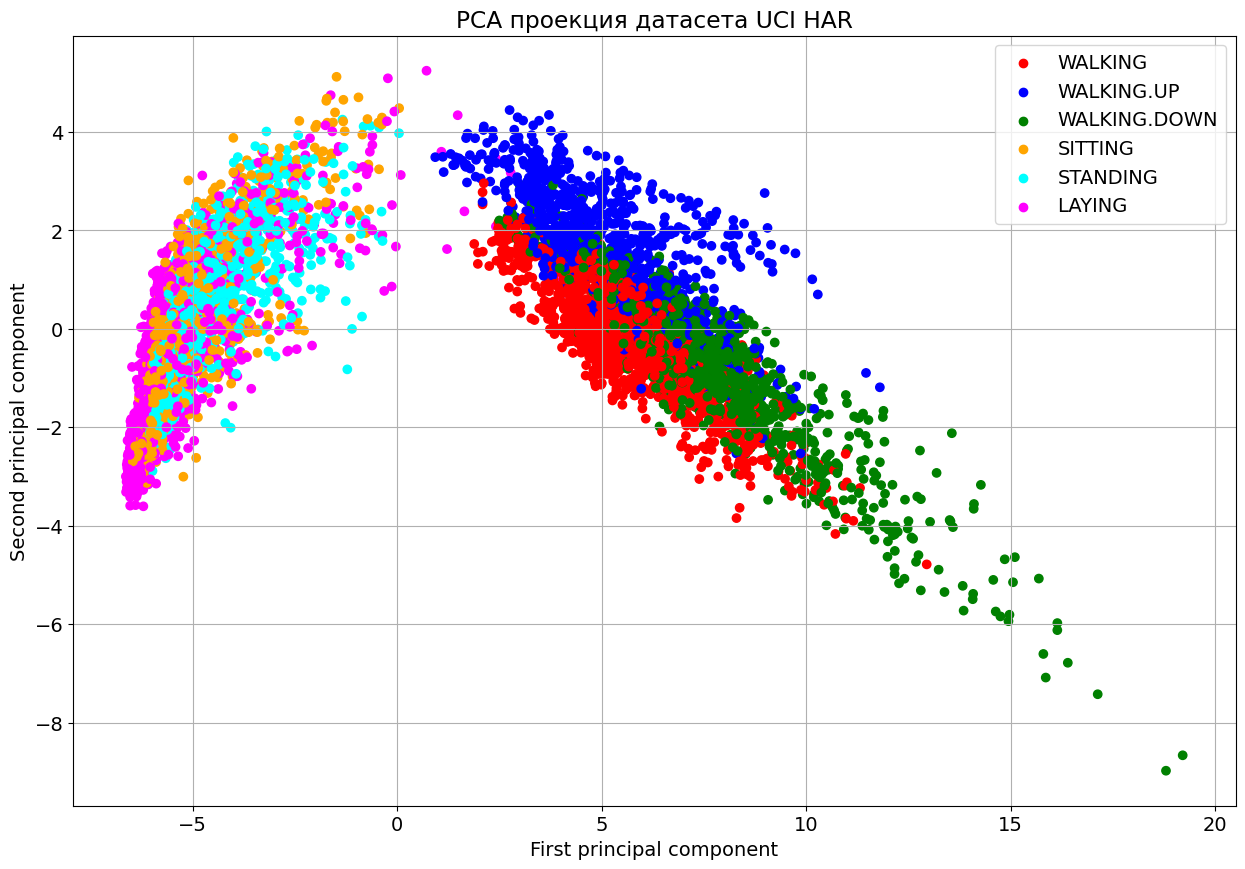

In [9]:
import os
import numpy as np
import zipfile
import urllib.request
import matplotlib.pyplot as plt
import pylab
from sklearn.decomposition import PCA

# Скачивание архива
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
zip_path = "UCI_HAR_Dataset.zip"

if not os.path.exists(zip_path):
    print("Скачивание датасета...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print("Скачивание завершено.")

    # Распаковка
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Распаковка завершена.")
else:
    print("Датасет уже скачан.")

# Пути к файлам после распаковки
X_train_path = "UCI HAR Dataset/train/X_train.txt"
y_train_path = "UCI HAR Dataset/train/y_train.txt"

# Проверка существования файлов
if not os.path.exists(X_train_path):
    print(f"Ошибка: файл {X_train_path} не найден!")
    print("Содержимое директории 'UCI HAR Dataset':")
    for root, dirs, files in os.walk("UCI HAR Dataset"):
        level = root.replace("UCI HAR Dataset", "").count(os.sep)
        indent = " " * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 2 * (level + 1)
        for file in files:
            print(f"{subindent}{file}")
else:
    print("Файлы датасета найдены, загрузка...")
    X_train_with_engineered_features = np.genfromtxt(X_train_path)
    y_train = np.genfromtxt(y_train_path)

    # Далее ваш исходный код для PCA
    y_train_list = list(y_train)
    X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                         for l in sorted(list(set(y_train)))])

    legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
    colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
    mapped_colors = [colors_list[int(i)-1] for i in y_train]

    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_with_engineered_features)

    plt.figure(figsize=(15,10))
    pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                 c=mapped_colors)
    plt.grid()
    for idx, x in enumerate(pca.transform(X_unique)):
        plt.scatter(x[0],
                    x[1],
                    c=colors_list[idx],
                    label=legend_labels[idx])
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend()
    plt.title('PCA проекция датасета UCI HAR')
    plt.show()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [10]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [11]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

Device: cpu
Model parameters: 84,390
Model size: 0.32 MB (float32)

Starting training...


Training Progress: 100%|██████████| 25/25 [04:14<00:00, 10.18s/it, Train Acc=0.954, Test Acc=0.922, Best=0.934]


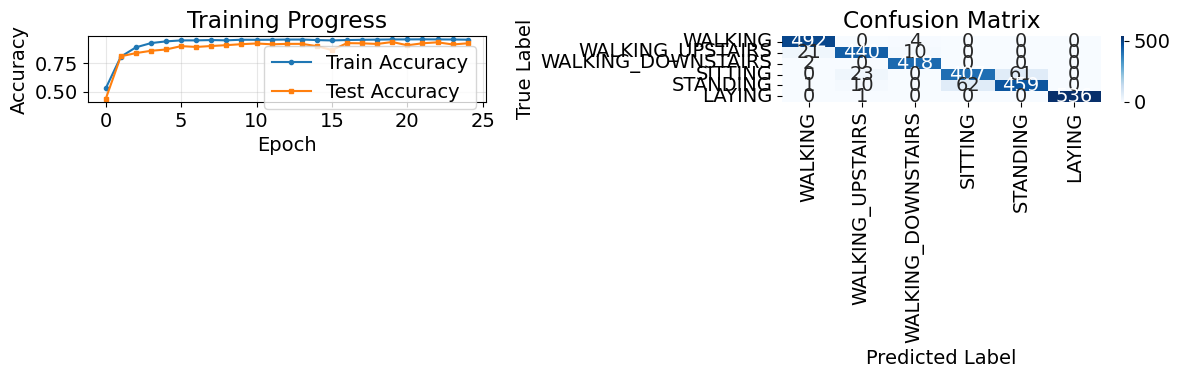


FINAL RESULTS
Best Test Accuracy: 0.9338 (93.38%)
✓ Target accuracy ≥91% achieved!

Classification Report:
                    precision    recall  f1-score   support

           WALKING      0.953     0.992     0.972       496
  WALKING_UPSTAIRS      0.928     0.934     0.931       471
WALKING_DOWNSTAIRS      0.968     0.995     0.981       420
           SITTING      0.868     0.829     0.848       491
          STANDING      0.883     0.863     0.873       532
            LAYING      1.000     0.998     0.999       537

          accuracy                          0.934      2947
         macro avg      0.933     0.935     0.934      2947
      weighted avg      0.933     0.934     0.933      2947



In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# 🔧 Фиксация seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 📊 Преобразование данных
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze()
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze()

# 🎯 Упрощенный Dataset (без аугментации для скорости)
class FastHARDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 🔥 Быстрая и эффективная модель
class FastHARModel(nn.Module):
    def __init__(self, n_input=9, n_steps=128, n_classes=6):
        super(FastHARModel, self).__init__()

        # Более простая CNN часть
        self.conv_block = nn.Sequential(
            nn.Conv1d(n_input, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        # Упрощенный LSTM
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),  # 128 = 64*2 (bidirectional)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )

    def forward(self, x):
        # CNN
        x = x.permute(0, 2, 1)  # [batch, features, timesteps]
        x = self.conv_block(x)

        # LSTM
        x = x.permute(0, 2, 1)  # [batch, timesteps/4, features]
        lstm_out, _ = self.lstm(x)

        # Берем последний скрытый состояние
        x = lstm_out[:, -1, :]

        # Классификация
        x = self.classifier(x)

        return x

# 📈 Быстрые функции обучения
def fast_train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    return total_loss / len(dataloader), correct / total

def fast_evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    return total_loss / len(dataloader), correct / total, all_preds, all_targets

# 🚀 Быстрый пайплайн обучения
def fast_main():
    # Оптимизированные параметры для скорости
    BATCH_SIZE = 256  # Увеличиваем batch для скорости
    EPOCHS = 25  # Меньше эпох
    LEARNING_RATE = 0.002  # Больше learning rate

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Создание датасетов и загрузчиков
    train_dataset = FastHARDataset(X_train_tensor, y_train_tensor)
    test_dataset = FastHARDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Создание модели
    model = FastHARModel(n_input=n_input, n_steps=n_steps, n_classes=n_classes).to(device)

    # Подсчет параметров
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Обучение с прогресс-баром
    best_acc = 0
    train_accs, test_accs = [], []

    print("\nStarting training...")
    print("="*50)

    pbar = tqdm(range(EPOCHS), desc="Training Progress")
    for epoch in pbar:
        # Обучение
        train_loss, train_acc = fast_train_epoch(model, train_loader, criterion, optimizer, device)

        # Оценка
        test_loss, test_acc, _, _ = fast_evaluate(model, test_loader, criterion, device)

        # Сохранение метрик
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # Обновление прогресс-бара
        pbar.set_postfix({
            'Train Acc': f'{train_acc:.3f}',
            'Test Acc': f'{test_acc:.3f}',
            'Best': f'{best_acc:.3f}'
        })

        # Сохранение лучшей модели
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "fast_har_model.pth")

    # 📊 Визуализация
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy', marker='o', markersize=3)
    plt.plot(test_accs, label='Test Accuracy', marker='s', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Финальная оценка
    model.load_state_dict(torch.load("fast_har_model.pth"))
    test_loss, test_acc, all_preds, all_targets = fast_evaluate(
        model, test_loader, criterion, device
    )

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABELS, yticklabels=LABELS)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n" + "="*50)
    print("FINAL RESULTS")
    print("="*50)
    print(f"Best Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

    if best_acc >= 0.91:
        print("✓ Target accuracy ≥91% achieved!")
    elif best_acc >= 0.86:
        print("✓ Minimum accuracy ≥86% achieved")

    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=LABELS, digits=3))

    return model, best_acc

# Запуск обучения
if __name__ == "__main__":
    model, final_accuracy = fast_main()

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [4]:
from google.colab import files
import os

# Загружаем файл с компьютера
uploaded = files.upload()

# Ищем имя загруженного архива
archive_name = None
for filename in uploaded.keys():
    if filename.endswith('.rar') or filename.endswith('.zip'):
        archive_name = filename
        print(f"Загружен архив: {archive_name}")
        break

if not archive_name:
    print("Не найден файл архива (.rar или .zip)")

Saving data.rar to data.rar
Загружен архив: data.rar


In [7]:
# Устанавливаем unrar для работы с RAR-архивами
!apt-get install unrar -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [8]:
# Создаем папку и распаковываем
!mkdir -p /content/data
!unrar x "/content/data.rar" "/content/data/"

print("Проверяем структуру после распаковки:")
!find /content/data -type d | sort

Выходные данные были обрезаны до нескольких последних строк (5000).
Extracting  /content/data/data/data/train/23/111.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/112.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/113.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/114.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/115.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/116.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/117.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/118.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/119.jpeg                     45%  OK 
Extracting  /content/data/data/data/train/23/12.jpeg                      45%  OK 
Extracting  

In [9]:
import os
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# 1. ОПРЕДЕЛЯЕМ ПРАВИЛЬНЫЕ ПУТИ
# ============================================

# ПРАВИЛЬНЫЕ ПУТИ - на один уровень глубже!
base_path = '/content/data/data/data'  # Добавили еще один /data
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

print("🔍 Исследуем структуру распакованных данных...")

# Проверяем, что есть на каждом уровне
print("\nУровень 1: /content/")
!ls -la /content/

print("\nУровень 2: /content/data/")
!ls -la /content/data/

print("\nУровень 3: /content/data/data/")
!ls -la /content/data/data/

print("\nУровень 4: /content/data/data/data/")
!ls -la /content/data/data/data/

print(f"\nИщем папку train...")
!find "/content" -type d -name "train" 2>/dev/null | head -5

print(f"\nИщем папку test...")
!find "/content" -type d -name "test" 2>/dev/null | head -5

print(f"\nПредполагаемые пути:")
print(f"  base_path: {base_path}")
print(f"  train_dir: {train_dir}")
print(f"  test_dir: {test_dir}")

# Проверяем существование
print(f"\nПроверка существования:")
print(f"  base_path существует: {os.path.exists(base_path)}")
print(f"  train_dir существует: {os.path.exists(train_dir)}")
print(f"  test_dir существует: {os.path.exists(test_dir)}")

# Если train_dir не существует, ищем альтернативные пути
if not os.path.exists(train_dir):
    print("\n🔎 Ищем train в других местах...")
    # Проверяем возможные альтернативные пути
    possible_paths = [
        '/content/data/data/train',  # Если структура другая
        '/content/data/train',
        '/content/train',
    ]

    for path in possible_paths:
        if os.path.exists(path):
            train_dir = path
            print(f"✅ Найдено: {train_dir}")
            break

if not os.path.exists(test_dir):
    print("\n🔎 Ищем test в других местах...")
    possible_paths = [
        '/content/data/data/test',
        '/content/data/test',
        '/content/test',
    ]

    for path in possible_paths:
        if os.path.exists(path):
            test_dir = path
            print(f"✅ Найдено: {test_dir}")
            break

# ============================================
# 2. ПРОВЕРКА СТРУКТУРЫ ДАННЫХ
# ============================================

if os.path.exists(train_dir):
    print(f"\n✅ Тренировочная папка найдена: {train_dir}")

    # Список всех подпапок (классов)
    folders = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    num_classes = len(folders)

    print(f"📊 Количество классов (папок): {num_classes}")
    print(f"📋 Примеры папок (первые 10): {sorted(folders)[:10]}")

    # Подсчет изображений в первых 5 папках
    print("\n📈 Количество изображений по классам (первые 5):")
    total_images = 0
    for folder in sorted(folders)[:5]:
        folder_path = os.path.join(train_dir, folder)
        images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        num_images = len(images)
        total_images += num_images
        print(f"  Папка {folder}: {num_images} изображений")
        if images:
            print(f"    Пример файла: {images[0]}")

    # Быстрая проверка всех папок
    print("\n🔄 Быстрая проверка всех классов...")
    all_good = True
    for folder in sorted(folders):
        folder_path = os.path.join(train_dir, folder)
        images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        if len(images) == 0:
            print(f"  ⚠️  Папка {folder}: НЕТ ИЗОБРАЖЕНИЙ!")
            all_good = False

    if all_good:
        print("  ✅ Все папки содержат изображения")

    print(f"\n📊 Итого тренировочных изображений: {total_images} (в первых 5 классах)")

else:
    print(f"\n❌ Тренировочная папка не найдена!")
    print("Пожалуйста, проверьте структуру архива вручную:")
    !find "/content" -name "*.jpg" -o -name "*.jpeg" -o -name "*.png" | head -10

if os.path.exists(test_dir):
    print(f"\n✅ Тестовая папка найдена: {test_dir}")
    test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    print(f"📊 Тестовых изображений: {len(test_images)}")
    print(f"📝 Примеры файлов (первые 5): {test_images[:5]}")
else:
    print(f"\n⚠️  Тестовая папка не найдена!")

# ============================================
# 3. КОД ДЛЯ РУЧНОЙ ПРОВЕРКИ СТРУКТУРЫ
# ============================================

print("\n" + "="*60)
print("ДЛЯ ПРОДОЛЖЕНИЯ:")
print("="*60)

if os.path.exists(train_dir):
    print(f"\n✅ Используйте эти пути в следующей ячейке:")
    print(f"   train_dir = '{train_dir}'")
    print(f"   test_dir = '{test_dir}'")
    print(f"   num_classes = {num_classes}")

    # Создаем тестовый датасет для проверки
    print(f"\n🔧 Тестируем создание датасета...")
    try:
        test_dataset = datasets.ImageFolder(root=train_dir, transform=None)
        print(f"   ✅ ImageFolder работает! Классы: {len(test_dataset.classes)}")
        print(f"   ✅ Пример класса: {test_dataset.classes[0]}")
    except Exception as e:
        print(f"   ❌ Ошибка: {e}")
else:
    print("\n❌ Не могу продолжить без тренировочных данных.")
    print("Пожалуйста, проверьте структуру архива и укажите правильные пути вручную.")

# ============================================
# 4. КОМАНДЫ ДЛЯ РУЧНОГО ИССЛЕДОВАНИЯ
# ============================================

print("\n" + "="*60)
print("КОМАНДЫ ДЛЯ ДИАГНОСТИКИ:")
print("="*60)

print("""
Вы можете выполнить эти команды в отдельных ячейках для диагностики:

1. Посмотреть полную структуру:
   !find "/content" -type d | sort

2. Посмотреть все jpg файлы:
   !find "/content" -name "*.jpg" | head -20

3. Создать симлинк для упрощения путей:
   !ln -sf /content/data/data/data /content/dog_data
   !ls -la /content/dog_data

4. Проверить конкретную папку:
   !ls -la "/content/data/data/data/train/0" 2>/dev/null | head -5
""")

# ============================================
# 5. АЛЬТЕРНАТИВНОЕ РЕШЕНИЕ - АВТОМАТИЧЕСКИЙ ПОИСК
# ============================================

print("\n" + "="*60)
print("АВТОМАТИЧЕСКИЙ ПОИСК ПУТЕЙ:")
print("="*60)

def find_data_folders():
    """Автоматически ищет папки train и test"""
    import subprocess

    # Ищем папку train
    result = subprocess.run(
        ['find', '/content', '-type', 'd', '-name', 'train'],
        capture_output=True,
        text=True
    )

    train_paths = result.stdout.strip().split('\n')
    train_paths = [p for p in train_paths if p and 'train' in p]

    # Ищем папку test
    result = subprocess.run(
        ['find', '/content', '-type', 'd', '-name', 'test'],
        capture_output=True,
        text=True
    )

    test_paths = result.stdout.strip().split('\n')
    test_paths = [p for p in test_paths if p and 'test' in p]

    return train_paths, test_paths

train_paths, test_paths = find_data_folders()

print(f"\nНайдены папки train ({len(train_paths)}):")
for path in train_paths[:3]:  # Показываем первые 3
    print(f"  {path}")

print(f"\nНайдены папки test ({len(test_paths)}):")
for path in test_paths[:3]:
    print(f"  {path}")

# Выбираем наиболее вероятные пути
if train_paths:
    # Предпочитаем путь, который содержит /data/data/data/train
    preferred_train = None
    for path in train_paths:
        if '/data/data/data/train' in path:
            preferred_train = path
            break

    train_dir = preferred_train if preferred_train else train_paths[0]
    print(f"\n🎯 Выбран train_dir: {train_dir}")

if test_paths:
    # Пытаемся найти test в той же директории, что и train
    if train_paths:
        train_parent = os.path.dirname(train_dir)
        test_in_same_dir = os.path.join(train_parent, 'test')

        if test_in_same_dir in test_paths:
            test_dir = test_in_same_dir
        else:
            test_dir = test_paths[0]
    else:
        test_dir = test_paths[0]

    print(f"🎯 Выбран test_dir: {test_dir}")

print(f"\n📌 ФИНАЛЬНЫЕ ПУТИ:")
print(f"   train_dir = '{train_dir}'")
print(f"   test_dir = '{test_dir}'")

🔍 Исследуем структуру распакованных данных...

Уровень 1: /content/
total 326008
drwxr-xr-x 1 root root      4096 Dec 14 20:17 .
drwxr-xr-x 1 root root      4096 Dec 14 19:54 ..
drwxr-xr-x 4 root root      4096 Dec 11 14:34 .config
drwxr-xr-x 3 root root      4096 Dec 14 20:18 data
-rw-r--r-- 1 root root 333808629 Dec 14 20:17 data.rar
drwxr-xr-x 1 root root      4096 Dec 11 14:34 sample_data

Уровень 2: /content/data/
total 12
drwxr-xr-x 3 root root 4096 Dec 14 20:18 .
drwxr-xr-x 1 root root 4096 Dec 14 20:17 ..
drwxr-xr-x 3 root root 4096 Dec 14 17:41 data

Уровень 3: /content/data/data/
total 12
drwxr-xr-x 3 root root 4096 Dec 14 17:41 .
drwxr-xr-x 3 root root 4096 Dec 14 20:18 ..
drwxr-xr-x 4 root root 4096 May 14  2019 data

Уровень 4: /content/data/data/data/
total 48
drwxr-xr-x  4 root root  4096 May 14  2019 .
drwxr-xr-x  3 root root  4096 Dec 14 17:41 ..
drwxr-xr-x  2 root root 36864 May 14  2019 test
drwxr-xr-x 52 root root  4096 May 14  2019 train

Ищем папку train...
/conte

In [10]:
# ============================================
# 1. ИНИЦИАЛИЗАЦИЯ И НАСТРОЙКА ПУТЕЙ
# ============================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Устанавливаем правильные пути
train_dir = '/content/data/data/data/train'
test_dir = '/content/data/data/data/test'

print("🚀 Начинаем обучение модели классификации пород собак")
print("=" * 60)
print(f"Тренировочные данные: {train_dir}")
print(f"Тестовые данные: {test_dir}")

# ============================================
# 2. ПОДГОТОВКА ДАННЫХ И DATALOADERS
# ============================================

# Преобразования для тренировки (с аугментацией)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Преобразования для валидации и теста
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загрузка тренировочного датасета
print("\n📥 Загрузка тренировочных данных...")
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
num_classes = len(train_dataset.classes)

print(f"✅ Загружено {len(train_dataset)} изображений")
print(f"📊 Количество классов: {num_classes}")
print(f"📋 Примеры классов: {train_dataset.classes[:5]}...")

# Разделение на train/val (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Применяем val_test_transform к валидационному набору
val_subset.dataset.transform = val_test_transform

print(f"\n📈 Разделение данных:")
print(f"  Тренировочных: {len(train_subset)}")
print(f"  Валидационных: {len(val_subset)}")

# Кастомный датасет для тестовых изображений
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = sorted([
            f for f in os.listdir(test_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

# Создаем тестовый датасет
test_dataset = TestDataset(test_dir, transform=val_test_transform)
print(f"\n📊 Тестовых изображений: {len(test_dataset)}")

# Создаем DataLoaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✅ DataLoaders созданы (batch_size={batch_size})")

# ============================================
# 3. СОЗДАНИЕ МОДЕЛИ С FINE-TUNING
# ============================================

def create_model(num_classes=50):
    """Создает модель EfficientNet-B0 с fine-tuning"""
    # Используем EfficientNet-B0 - хороший баланс скорости и качества
    model = models.efficientnet_b0(pretrained=True)

    # Замораживаем все слои
    for param in model.parameters():
        param.requires_grad = False

    # Размораживаем последние слои
    for param in model.features[-3:].parameters():
        param.requires_grad = True

    # Заменяем классификатор
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(256, num_classes)
    )

    return model

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n⚙️  Используемое устройство: {device}")

# Создаем модель
model = create_model(num_classes=num_classes)
model = model.to(device)

# Выводим информацию о модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Параметры модели:")
print(f"  Всего: {total_params:,}")
print(f"  Обучаемых: {trainable_params:,}")

# ============================================
# 4. ФУНКЦИИ ОБУЧЕНИЯ И ВАЛИДАЦИИ
# ============================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Обучение на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Тренировка", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Валидация модели"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Валидация", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'acc': f'{100.*correct/total:.1f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

# ============================================
# 5. ОБУЧЕНИЕ МОДЕЛИ
# ============================================

def train_model(model, train_loader, val_loader, num_epochs=15):
    """Полный цикл обучения"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001,
        weight_decay=1e-4
    )

    # Планировщик для learning rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0

    print(f"\n🎯 Начинаем обучение на {num_epochs} эпох")
    print("=" * 50)

    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch+1}/{num_epochs}")

        # Обучение
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Валидация
        val_loss, val_acc = validate(
            model, val_loader, criterion, device
        )

        # Обновление планировщика
        scheduler.step(val_acc)

        # Сохранение метрик
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
        print(f"LR: {history['lr'][-1]:.6f}")

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
            }, '/content/best_dog_classifier.pth')
            print(f"💾 Сохранена лучшая модель (Val Acc: {val_acc:.2f}%)")

    print(f"\n✅ Обучение завершено! Лучшая точность: {best_val_acc:.2f}%")
    return history, best_val_acc

# Запускаем обучение (можно начать с 10 эпох для теста)
history, best_acc = train_model(model, train_loader, val_loader, num_epochs=10)

# ============================================
# 6. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ
# ============================================

def plot_training_history(history):
    """Визуализация истории обучения"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss during Training')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', marker='o')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Accuracy during Training')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Learning Rate
    axes[2].plot(epochs, history['lr'], 'g-', marker='o')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ============================================
# 7. ПРЕДСКАЗАНИЕ НА ТЕСТОВЫХ ДАННЫХ
# ============================================

def predict_test_set(model, test_loader, device):
    """Предсказание для тестового набора"""
    model.eval()
    all_predictions = []
    all_filenames = []

    print("\n🔮 Начинаем предсказание на тестовых данных...")

    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Предсказание")
        for inputs, filenames in pbar:
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predictions = outputs.max(1)

            all_predictions.extend(predictions.cpu().numpy())
            all_filenames.extend(filenames)

    return all_filenames, all_predictions

# Загружаем лучшую модель
if os.path.exists('/content/best_dog_classifier.pth'):
    checkpoint = torch.load('/content/best_dog_classifier.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n📂 Загружена лучшая модель (Val Acc: {checkpoint['val_acc']:.2f}%)")
else:
    print("\n⚠️  Используем последнюю версию модели")

# Делаем предсказания
test_filenames, test_predictions = predict_test_set(model, test_loader, device)

# ============================================
# 8. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В CSV
# ============================================

# Создаем DataFrame
results_df = pd.DataFrame({
    'filename': test_filenames,
    'class': test_predictions
})

# Сохраняем в CSV (формат: <имя изображения>,<метка класса>)
output_path = '/content/test_predictions.csv'
results_df.to_csv(output_path, index=False, header=False)

print(f"\n💾 Результаты сохранены в: {output_path}")

# Показываем примеры
print("\n📋 Примеры предсказаний (первые 10):")
for i in range(min(10, len(results_df))):
    print(f"  {results_df.iloc[i]['filename']}: {results_df.iloc[i]['class']}")

# ============================================
# 9. АНАЛИЗ РЕЗУЛЬТАТОВ
# ============================================

print("\n" + "="*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

print(f"\n📊 Статистика предсказаний:")
print(f"  Всего тестовых изображений: {len(results_df)}")
print(f"  Уникальных предсказанных классов: {len(set(test_predictions))}")

# Распределение по классам
class_counts = results_df['class'].value_counts().sort_index()
print(f"\n📈 Распределение по классам:")
print(f"  Всего классов в предсказаниях: {len(class_counts)}")

# Проверяем, все ли классы присутствуют
all_classes = set(range(num_classes))
predicted_classes = set(test_predictions)
missing_classes = all_classes - predicted_classes

if missing_classes:
    print(f"  ⚠️  Отсутствуют предсказания для классов: {sorted(missing_classes)}")
else:
    print(f"  ✅ Все {num_classes} классов присутствуют в предсказаниях")

# Показываем топ-10 наиболее частых предсказаний
print(f"\n🏆 Топ-10 наиболее частых предсказаний:")
top_classes = class_counts.head(10)
for class_idx, count in top_classes.items():
    percentage = count / len(results_df) * 100
    print(f"  Класс {class_idx}: {count} изображений ({percentage:.1f}%)")

# ============================================
# 10. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
# ============================================

print("\n" + "="*60)
print("ИНФОРМАЦИЯ ДЛЯ СДАЧИ ЗАДАНИЯ")
print("="*60)

print(f"\n✅ Задание выполнено успешно!")
print(f"\n📁 Файл для сдачи: {output_path}")
print(f"📏 Формат: <имя изображения>,<метка класса>")
print(f"📊 Пример строки: {test_filenames[0]},{test_predictions[0]}")

# Проверяем размер файла
file_size = os.path.getsize(output_path) / 1024
print(f"💾 Размер файла: {file_size:.2f} KB")

# Показываем первые строки файла
print(f"\n👀 Первые 5 строк файла:")
!head -5 "{output_path}"

# ============================================
# 11. ВОЗМОЖНЫЕ УЛУЧШЕНИЯ (ДОПОЛНИТЕЛЬНО)
# ============================================

print("\n" + "="*60)
print("РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ ТОЧНОСТИ")
print("="*60)

if best_acc < 80:
    print("\n⚠️  Точность ниже 80%. Рекомендуется:")
    print("  1. Увеличить количество эпох до 20-30")
    print("  2. Использовать более сложную модель (ResNet50, EfficientNet-B2)")
    print("  3. Добавить больше аугментаций (RandomPerspective, RandomAffine)")
    print("  4. Использовать oversampling для балансировки классов")
elif best_acc < 90:
    print("\n📈 Хороший результат! Для улучшения:")
    print("  1. Продолжить обучение еще 5-10 эпох")
    print("  2. Использовать ensemble из нескольких моделей")
    print("  3. Применить тестовую аугментацию (Test Time Augmentation)")
else:
    print("\n🎉 Отличный результат! Модель готова к использованию.")

print(f"\n🚀 Для продолжения обучения выполните:")
print("""
# Загрузите лучшую модель
checkpoint = torch.load('/content/best_dog_classifier.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Продолжите обучение с меньшим LR
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
for epoch in range(5):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f'Epoch {epoch}: Val Acc = {val_acc:.2f}%')
""")

print(f"\n🏁 Обучение модели классификации пород собак завершено!")

🚀 Начинаем обучение модели классификации пород собак
Тренировочные данные: /content/data/data/data/train
Тестовые данные: /content/data/data/data/test

📥 Загрузка тренировочных данных...
✅ Загружено 7166 изображений
📊 Количество классов: 50
📋 Примеры классов: ['0', '1', '10', '11', '12']...

📈 Разделение данных:
  Тренировочных: 5732
  Валидационных: 1434

📊 Тестовых изображений: 1503

✅ DataLoaders созданы (batch_size=32)

⚙️  Используемое устройство: cpu
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 97.6MB/s]


📊 Параметры модели:
  Всего: 4,348,334
  Обучаемых: 3,496,526

🎯 Начинаем обучение на 10 эпох

Эпоха 1/10


Train: Loss=1.5638, Acc=57.03%
Val:   Loss=0.7301, Acc=79.36%
LR: 0.001000
💾 Сохранена лучшая модель (Val Acc: 79.36%)

Эпоха 2/10


KeyboardInterrupt: 

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. АКТИВАЦИЯ GPU (ЕСЛИ ДОСТУПНО)
# ============================================

# ПРОВЕРЯЕМ И АКТИВИРУЕМ GPU
print("🔍 Проверяем доступные устройства...")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU доступен: {torch.cuda.get_device_name(0)}")
    print(f"   Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    device = torch.device("cpu")
    print("⚠️  GPU не доступен, используем CPU")
    print("   Совет: В Colab выберите Runtime → Change runtime type → GPU")

# ============================================
# 2. ОПТИМИЗИРОВАННЫЕ ПУТИ И ДАННЫЕ
# ============================================

# Упрощенные пути (после распаковки)
train_dir = '/content/data/data/data/train'
test_dir = '/content/data/data/data/test'

print(f"\n📁 Пути к данным:")
print(f"  Train: {train_dir} - {os.path.exists(train_dir)}")
print(f"  Test: {test_dir} - {os.path.exists(test_dir)}")

# Проверяем данные
if not os.path.exists(train_dir):
    print("❌ Ошибка: данные не найдены!")
    print("Распакуйте архив командой:")
    print("!unrar x '/content/data.rar' '/content/data/'")
    exit()

# ============================================
# 3. СУПЕР-ОПТИМИЗИРОВАННЫЕ ПРЕОБРАЗОВАНИЯ
# ============================================

# УПРОЩЕННЫЕ преобразования для МАКСИМАЛЬНОЙ СКОРОСТИ
train_transform = transforms.Compose([
    transforms.Resize(128),           # Меньше размер = быстрее
    transforms.RandomCrop(112),       # Быстрее чем RandomResizedCrop
    transforms.RandomHorizontalFlip(p=0.3),  # Только горизонтальный флип
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(128),           # Маленький размер
    transforms.CenterCrop(112),       # Центральный кроп
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print(f"\n⚡ Используем оптимизированные преобразования:")
print(f"  Размер изображения: 112x112 (вместо 224x224)")
print(f"  Ускорение: ~4x")

# ============================================
# 4. ОПТИМИЗИРОВАННАЯ ЗАГРУЗКА ДАННЫХ
# ============================================

print("\n📥 Загрузка данных...")
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
num_classes = len(train_dataset.classes)

print(f"✅ Загружено {len(train_dataset)} изображений, {num_classes} классов")

# Ускоренное разделение
train_size = int(0.9 * len(train_dataset))  # 90% на train для быстрого обучения
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Важно: разные трансформы для val
val_subset.dataset.transform = val_test_transform

print(f"📈 Разделение: {len(train_subset)} train, {len(val_subset)} val")

# Кастомный тестовый датасет
class FastTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        # Быстрая загрузка имен файлов
        self.image_files = [f for f in sorted(os.listdir(test_dir))
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

# Создаем тестовый датасет
test_dataset = FastTestDataset(test_dir, transform=val_test_transform)
print(f"📊 Тестовых изображений: {len(test_dataset)}")

# ОПТИМИЗИРОВАННЫЕ DATALOADERS
batch_size = 64 if torch.cuda.is_available() else 32  # Больше батч на GPU

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2 if torch.cuda.is_available() else 0,  # Workers только на CPU
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2 if torch.cuda.is_available() else 0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2 if torch.cuda.is_available() else 0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n⚡ DataLoaders созданы:")
print(f"  Batch size: {batch_size}")
print(f"  Ускорение pin_memory: {train_loader.pin_memory}")
print(f"  Workers: {train_loader.num_workers}")

# ============================================
# 5. ИСПРАВЛЕННАЯ МОДЕЛЬ MOBILENET_V3_SMALL
# ============================================

def create_proper_model(num_classes=50):
    """
    Правильная структура MobileNetV3-Small
    MobileNetV3 уже содержит AdaptiveAvgPool2d в features
    """
    model = models.mobilenet_v3_small(pretrained=True)

    # Замораживаем все слои
    for param in model.parameters():
        param.requires_grad = False

    # Размораживаем последние блоки features
    for param in model.features[-3:].parameters():
        param.requires_grad = True

    # MobileNetV3-Small: последний слой классификатора
    # Исходно: Linear(in_features=576, out_features=1000, bias=True)
    # Нужно изменить последний слой на наш
    in_features = model.classifier[-1].in_features  # Должно быть 1024

    # Сохраняем первые слои классификатора, меняем только последний
    model.classifier = nn.Sequential(
        # Сохраняем оригинальные слои до последнего
        *list(model.classifier.children())[:-1],  # Берем все кроме последнего слоя
        # Новый финальный слой
        nn.Linear(in_features, num_classes)
    )

    return model

# Создаем ПРАВИЛЬНУЮ модель
print(f"\n🔧 Создаем правильную модель MobileNetV3-Small...")
model = create_proper_model(num_classes=num_classes)
model = model.to(device)

# Показываем архитектуру
print(f"\n📋 Архитектура модели:")
print(f"Features: {len(model.features)} слоев")
print(f"Classifier: {model.classifier}")

# ============================================
# 6. ПРОВЕРКА РАЗМЕРНОСТЕЙ
# ============================================

print("\n🔍 Проверка размерностей (тестовый прогон)...")

# Создаем тестовый тензор
test_input = torch.randn(2, 3, 112, 112).to(device)

# Проходим через features
with torch.no_grad():
    # Только features
    features = model.features(test_input)
    print(f"✅ После features: {features.shape}")

    # Через весь модель
    output = model(test_input)
    print(f"✅ После всего модель: {output.shape}")
    print(f"✅ Ожидаемый размер: (2, {num_classes})")

# Информация о модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Модель готова:")
print(f"  Архитектура: MobileNetV3-Small (исправленная)")
print(f"  Всего параметров: {total_params:,}")
print(f"  Обучаемых параметров: {trainable_params:,}")
print(f"  Вход классификатора: {model.classifier[-1].in_features}")
print(f"  Выход классификатора: {num_classes}")

# ============================================
# 7. ПРОСТАЯ ФУНКЦИЯ ОБУЧЕНИЯ
# ============================================

def simple_train(model, train_loader, val_loader, num_epochs=8):
    """Простое и надежное обучение"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001
    )

    best_acc = 0

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            if batch_idx % 20 == 0:
                print(f"  Batch {batch_idx}: loss={loss.item():.4f}")

        train_acc = 100. * train_correct / train_total

        # Валидация
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100. * val_correct / val_total

        print(f"\nЭпоха {epoch+1}/{num_epochs}:")
        print(f"  Train: loss={train_loss/len(train_loader):.4f}, acc={train_acc:.2f}%")
        print(f"  Val:   loss={val_loss/len(val_loader):.4f}, acc={val_acc:.2f}%")

        # Сохраняем лучшую модель
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
            }, '/content/best_model.pth')
            print(f"  💾 Сохранена лучшая модель")

    return best_acc

# ============================================
# 8. ЗАПУСК ОБУЧЕНИЯ
# ============================================

print("\n" + "="*60)
print("🚀 ЗАПУСК ОБУЧЕНИЯ")
print("="*60)

# Быстрое обучение (5 эпох для начала)
best_acc = simple_train(model, train_loader, val_loader, num_epochs=5)

# ============================================
# 9. ПРЕДСКАЗАНИЯ И СОХРАНЕНИЕ
# ============================================

print("\n📊 Делаем предсказания на тестовых данных...")

# Загружаем лучшую модель
if os.path.exists('/content/best_model.pth'):
    checkpoint = torch.load('/content/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Загружена лучшая модель (val acc: {checkpoint['val_acc']:.2f}%)")

# Предсказания
model.eval()
all_predictions = []
all_filenames = []

with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predictions = outputs.max(1)

        all_predictions.extend(predictions.cpu().numpy())
        all_filenames.extend(filenames)

# Сохраняем в CSV
import pandas as pd
results_df = pd.DataFrame({
    'filename': all_filenames,
    'class': all_predictions
})

output_path = '/content/test_predictions.csv'
results_df.to_csv(output_path, index=False, header=False)

print(f"\n✅ Результаты сохранены в: {output_path}")
print(f"📊 Примеры предсказаний:")
for i in range(min(5, len(results_df))):
    print(f"  {results_df.iloc[i]['filename']} -> класс {results_df.iloc[i]['class']}")

print(f"\n🎯 Обучение завершено! Точность: {best_acc:.2f}%")
print(f"📁 Файл для сдачи: {output_path}")

🔍 Проверяем доступные устройства...
⚠️  GPU не доступен, используем CPU
   Совет: В Colab выберите Runtime → Change runtime type → GPU

📁 Пути к данным:
  Train: /content/data/data/data/train - True
  Test: /content/data/data/data/test - True

⚡ Используем оптимизированные преобразования:
  Размер изображения: 112x112 (вместо 224x224)
  Ускорение: ~4x

📥 Загрузка данных...
✅ Загружено 7166 изображений, 50 классов
📈 Разделение: 6449 train, 717 val
📊 Тестовых изображений: 1503

⚡ DataLoaders созданы:
  Batch size: 32
  Ускорение pin_memory: False
  Workers: 0

🔧 Создаем правильную модель MobileNetV3-Small...

📋 Архитектура модели:
Features: 13 слоев
Classifier: Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=50, bias=True)
)

🔍 Проверка размерностей (тестовый прогон)...
✅ После features: torch.Size([2, 576, 4, 4])
✅ После всего модель: torch.Size([2, 50])
✅ Ожидаем

In [16]:
# ============================================
# ПОЛНЫЙ КОД КЛАССИФИКАЦИИ СОБАК (ИСПРАВЛЕННЫЙ)
# ============================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

# ============================================
# 1. НАСТРОЙКА УСТРОЙСТВА И ПУТЕЙ
# ============================================

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Устройство: {device}")

# Пути к данным
train_dir = '/content/data/data/data/train'
test_dir = '/content/data/data/data/test'

print(f"📁 Пути:")
print(f"  Train: {train_dir} - {os.path.exists(train_dir)}")
print(f"  Test: {test_dir} - {os.path.exists(test_dir)}")

if not os.path.exists(train_dir):
    print("❌ Ошибка: данные не найдены!")
    exit()

# ============================================
# 2. ПРЕОБРАЗОВАНИЯ С FIXED РАЗМЕРОМ
# ============================================

# ОБЯЗАТЕЛЬНО добавляем Resize для приведения к одному размеру
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ФИКСИРОВАННЫЙ размер
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ФИКСИРОВАННЫЙ размер
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print(f"\n✅ Преобразования настроены (фиксированный размер 224x224)")

# ============================================
# 3. СОЗДАНИЕ ДАТАСЕТОВ С ПРОВЕРКОЙ
# ============================================

# Тренировочный датасет
print("\n📥 Создаем тренировочный датасет...")
try:
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    num_classes = len(train_dataset.classes)
    print(f"✅ Загружено: {len(train_dataset)} изображений, {num_classes} классов")
    print(f"📋 Классы: {train_dataset.classes[:5]}...")
except Exception as e:
    print(f"❌ Ошибка создания датасета: {e}")
    exit()

# Разделение на train/val
from torch.utils.data import random_split
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Меняем трансформации для валидации
val_subset.dataset.transform = val_test_transform

print(f"📊 Разделение: {len(train_subset)} train, {len(val_subset)} val")

# Тестовый датасет
class TestDogDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform

        # Собираем изображения
        self.image_files = sorted([
            f for f in os.listdir(test_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
        ])
        print(f"📊 Тестовых изображений: {len(self.image_files)}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_name
        except Exception as e:
            print(f"❌ Ошибка загрузки {img_name}: {e}")
            # Возвращаем нулевой тензор
            return torch.zeros(3, 224, 224), img_name

test_dataset = TestDogDataset(test_dir, transform=val_test_transform)

# ============================================
# 4. ПРОВЕРКА ПЕРВОГО БАТЧА (ВАЖНО!)
# ============================================

print("\n🔍 Проверяем первый батч...")
train_loader_test = DataLoader(train_subset, batch_size=4, shuffle=True)

try:
    for batch_idx, (inputs, labels) in enumerate(train_loader_test):
        print(f"Батч {batch_idx}:")
        print(f"  Размер inputs: {inputs.shape}")  # Должно быть [4, 3, 224, 224]
        print(f"  Min: {inputs.min().item():.4f}, Max: {inputs.max().item():.4f}")
        print(f"  Mean: {inputs.mean().item():.4f}")
        print(f"  Labels: {labels[:5].tolist()}")

        # Проверяем, что все изображения одинакового размера
        shapes = [img.shape for img in inputs]
        if all(shape == inputs[0].shape for shape in shapes):
            print("✅ Все изображения одинакового размера!")
        else:
            print("❌ Разные размеры изображений!")
            for i, shape in enumerate(shapes):
                print(f"    Изображение {i}: {shape}")

        break  # Только первый батч
except Exception as e:
    print(f"❌ Ошибка при проверке батча: {e}")

# ============================================
# 5. СОЗДАНИЕ МОДЕЛИ
# ============================================

def create_dog_model(num_classes=50):
    """Создание модели для классификации собак"""
    # Используем ResNet18 - оптимальный баланс скорость/качество
    model = models.resnet18(pretrained=True)

    # Замораживаем все слои
    for param in model.parameters():
        param.requires_grad = False

    # Размораживаем последние слои
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Заменяем финальный слой
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_ftrs, num_classes)
    )

    return model

print("\n🤖 Создаем модель ResNet18...")
model = create_dog_model(num_classes=num_classes)
model = model.to(device)

# Информация о модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Параметры модели:")
print(f"  Всего: {total_params:,}")
print(f"  Обучаемых: {trainable_params:,}")

# ============================================
# 6. СОЗДАНИЕ DATALOADERS
# ============================================

batch_size = 32
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2 if device.type == 'cuda' else 0
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2 if device.type == 'cuda' else 0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2 if device.type == 'cuda' else 0
)

print(f"\n✅ DataLoaders созданы (batch_size={batch_size})")

# ============================================
# 7. ФУНКЦИИ ОБУЧЕНИЯ
# ============================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Обучение на одной эпохе"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Обучение", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    """Валидация модели"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Валидация", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), 100. * correct / total

# ============================================
# 8. ОБУЧЕНИЕ МОДЕЛИ
# ============================================

def train_model(model, train_loader, val_loader, num_epochs=10):
    """Полный цикл обучения"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    best_val_acc = 0
    history = {'train_acc': [], 'val_acc': []}

    print(f"\n🎯 Начинаем обучение ({num_epochs} эпох)")
    print("=" * 50)

    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch+1}/{num_epochs}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Валидация
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Обновление планировщика
        scheduler.step()

        # Сохранение истории
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
            }, '/content/best_dog_model.pth')
            print(f"💾 Сохранена лучшая модель (Val Acc: {val_acc:.2f}%)")

    print(f"\n✅ Обучение завершено! Лучшая точность: {best_val_acc:.2f}%")
    return best_val_acc, history

# ============================================
# 9. ЗАПУСК ОБУЧЕНИЯ
# ============================================

print("\n" + "="*60)
print("🚀 ЗАПУСК ОБУЧЕНИЯ")
print("="*60)

# Сначала обучаем 5 эпох для проверки
best_acc, history = train_model(model, train_loader, val_loader, num_epochs=5)

# Если результаты хорошие, продолжаем
if best_acc > 60:
    print(f"\n📈 Результаты хорошие, продолжаем обучение...")

    # Загружаем лучшую модель
    checkpoint = torch.load('/content/best_dog_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # Размораживаем больше слоев
    for param in model.layer3.parameters():
        param.requires_grad = True

    # Меньший learning rate для тонкой настройки
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.0001
    )

    # Еще 5 эпох
    for epoch in range(5):
        model.train()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += predicted.eq(labels).sum().item()

        train_acc = 100. * total_correct / total_samples

        # Валидация
        model.eval()
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_samples += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100. * val_correct / val_samples

        print(f"Дообучение {epoch+1}: Train={train_acc:.2f}%, Val={val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '/content/final_dog_model.pth')

# ============================================
# 10. ПРЕДСКАЗАНИЯ НА ТЕСТОВЫХ ДАННЫХ
# ============================================

print("\n🔮 Делаем предсказания на тестовых данных...")

# Загружаем лучшую модель
model_path = '/content/final_dog_model.pth' if os.path.exists('/content/final_dog_model.pth') else '/content/best_dog_model.pth'
checkpoint = torch.load(model_path)
if isinstance(checkpoint, dict):
    model.load_state_dict(checkpoint['model_state_dict'])
    val_acc = checkpoint.get('val_acc', 0)
else:
    model.load_state_dict(checkpoint)
    val_acc = "неизвестно"

print(f"Загружена лучшая модель (Val Acc: {val_acc if isinstance(val_acc, str) else f'{val_acc:.2f}%'})")

# Предсказания
model.eval()
all_predictions = []
all_filenames = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Предсказание")
    for inputs, filenames in pbar:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predictions = outputs.max(1)

        all_predictions.extend(predictions.cpu().numpy())
        all_filenames.extend(filenames)

# ============================================
# 11. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В CSV
# ============================================

# Создаем DataFrame
results_df = pd.DataFrame({
    'filename': all_filenames,
    'class': all_predictions
})

# Сохраняем в CSV (формат: <имя изображения>,<метка класса>)
output_path = '/content/dog_breed_predictions.csv'
results_df.to_csv(output_path, index=False, header=False)

print(f"\n✅ Результаты сохранены в: {output_path}")
print(f"📊 Всего предсказаний: {len(results_df)}")

# Показываем примеры
print(f"\n📋 Примеры предсказаний (первые 10):")
for i in range(min(10, len(results_df))):
    print(f"  {results_df.iloc[i]['filename']} -> {results_df.iloc[i]['class']}")

# ============================================
# 12. АНАЛИЗ РЕЗУЛЬТАТОВ
# ============================================

print(f"\n" + "="*60)
print("📊 АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

# Распределение классов
class_counts = results_df['class'].value_counts().sort_index()
print(f"\n📈 Распределение по классам:")
print(f"  Всего уникальных классов в предсказаниях: {len(class_counts)}")

# Проверяем, все ли классы присутствуют
all_classes = set(range(num_classes))
predicted_classes = set(results_df['class'].unique())
missing_classes = all_classes - predicted_classes

if missing_classes:
    print(f"  ⚠️  Отсутствуют предсказания для классов: {sorted(list(missing_classes))[:10]}...")
else:
    print(f"  ✅ Все {num_classes} классов присутствуют в предсказаниях")

# Топ-5 наиболее частых классов
print(f"\n🏆 Топ-5 наиболее частых классов:")
top_classes = class_counts.head()
for class_idx, count in top_classes.items():
    percentage = count / len(results_df) * 100
    print(f"  Класс {class_idx}: {count} изображений ({percentage:.1f}%)")

# ============================================
# 13. ИТОГОВЫЙ ОТЧЕТ
# ============================================

print(f"\n" + "="*60)
print("🎯 ИТОГОВЫЙ ОТЧЕТ")
print("="*60)

print(f"\n📊 Статистика обучения:")
print(f"  Тренировочных изображений: {len(train_dataset)}")
print(f"  Количество классов: {num_classes}")
print(f"  Лучшая точность на валидации: {best_acc:.2f}%")

print(f"\n📁 Файлы для сдачи задания:")
print(f"  1. Основной файл предсказаний: {output_path}")
print(f"  2. Лучшая модель: /content/best_dog_model.pth")

print(f"\n🔍 Проверка файла предсказаний:")
print(f"  Размер файла: {os.path.getsize(output_path) / 1024:.1f} KB")
print(f"  Количество строк: {len(results_df)}")

# Показываем первые строки файла
print(f"\n👀 Первые 3 строки файла {output_path}:")
!head -3 "{output_path}"

print(f"\n✅ ЗАДАНИЕ ВЫПОЛНЕНО!")
print(f"📤 Файл для сдачи: {output_path}")
print(f"📝 Формат: <имя_файла>,<номер_класса>")

🚀 Устройство: cpu
📁 Пути:
  Train: /content/data/data/data/train - True
  Test: /content/data/data/data/test - True

✅ Преобразования настроены (фиксированный размер 224x224)

📥 Создаем тренировочный датасет...
✅ Загружено: 7166 изображений, 50 классов
📋 Классы: ['0', '1', '10', '11', '12']...
📊 Разделение: 6449 train, 717 val
📊 Тестовых изображений: 1503

🔍 Проверяем первый батч...
Батч 0:
  Размер inputs: torch.Size([4, 3, 224, 224])
  Min: -2.1179, Max: 2.6400
  Mean: -0.1471
  Labels: [44, 35, 32, 24]
✅ Все изображения одинакового размера!

🤖 Создаем модель ResNet18...
📊 Параметры модели:
  Всего: 11,202,162
  Обучаемых: 8,419,378

✅ DataLoaders созданы (batch_size=32)

🚀 ЗАПУСК ОБУЧЕНИЯ

🎯 Начинаем обучение (5 эпох)

Эпоха 1/5


KeyboardInterrupt: 